In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

df = pd.read_csv('UberDataset.csv')
print(df.head())
print(df.info())
print(df.isna().sum())

         START_DATE          END_DATE  CATEGORY        START             STOP  \
0  01-01-2016 21:11  01-01-2016 21:17  Business  Fort Pierce      Fort Pierce   
1  01-02-2016 01:25  01-02-2016 01:37  Business  Fort Pierce      Fort Pierce   
2  01-02-2016 20:25  01-02-2016 20:38  Business  Fort Pierce      Fort Pierce   
3  01-05-2016 17:31  01-05-2016 17:45  Business  Fort Pierce      Fort Pierce   
4  01-06-2016 14:42  01-06-2016 15:49  Business  Fort Pierce  West Palm Beach   

   MILES          PURPOSE  
0    5.1   Meal/Entertain  
1    5.0              NaN  
2    4.8  Errand/Supplies  
3    4.7          Meeting  
4   63.7   Customer Visit  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156 entries, 0 to 1155
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   START_DATE  1156 non-null   object 
 1   END_DATE    1155 non-null   object 
 2   CATEGORY    1155 non-null   object 
 3   START       1155 non-null   o

In [2]:
# Preprocess data
# Missing value 
threshold = len(df)*0.005
print(threshold)
col_drop = df.columns[df.isna().sum() <= threshold]
print(col_drop)

df.dropna(subset = col_drop, inplace = True)
print(df.isna().sum())

5.78
Index(['START_DATE', 'END_DATE', 'CATEGORY', 'START', 'STOP', 'MILES'], dtype='object')
START_DATE      0
END_DATE        0
CATEGORY        0
START           0
STOP            0
MILES           0
PURPOSE       502
dtype: int64


In [3]:
df_dict = df.groupby('CATEGORY')['PURPOSE'].count().to_dict()
print(df_dict)
df["PURPOSE"] = df['PURPOSE'].fillna(df['PURPOSE'].mode()[0])

{'Business': 647, 'Personal': 6}


In [4]:
df['START_DATE'] = df['START_DATE'].str.replace('/','-')
df['START_DATE'] = pd.to_datetime(df['START_DATE'],
                              errors = 'coerce')
df['END_DATE'] = df['END_DATE'].str.replace('/','-')
df['END_DATE'] = pd.to_datetime(df['END_DATE'], 
                              errors = 'coerce')
df['date'] = df['START_DATE'].dt.date
df['time'] = df['START_DATE'].dt.hour
df.isna().sum()


START_DATE    0
END_DATE      0
CATEGORY      0
START         0
STOP          0
MILES         0
PURPOSE       0
date          0
time          0
dtype: int64

In [5]:
df['day-night'] = pd.cut(x = df['time'],
                         bins = [-0.0001,10,15,19,24],
                         labels = ['morning','afternoon','evening','night'])

df['day-night'].isna().sum()
df.drop_duplicates(inplace = True)

In [6]:
obj_col = df.select_dtypes(include = 'object').columns
unique = {}
for col in obj_col:
    unique[col] = df[col].nunique()
print(unique)

{'CATEGORY': 2, 'START': 177, 'STOP': 188, 'PURPOSE': 10, 'date': 294}


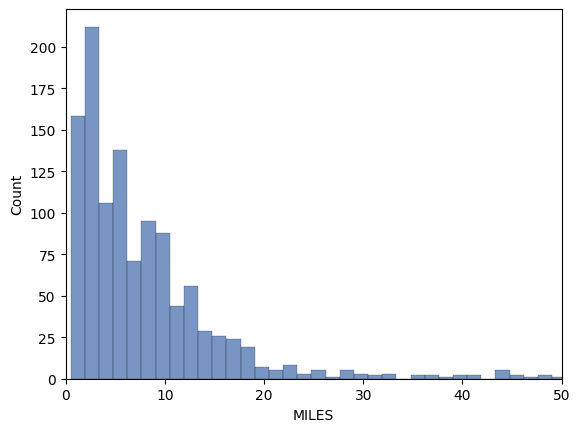

In [75]:
sns.histplot(df['MILES'])
plt.xlim(0,50)
plt.show()

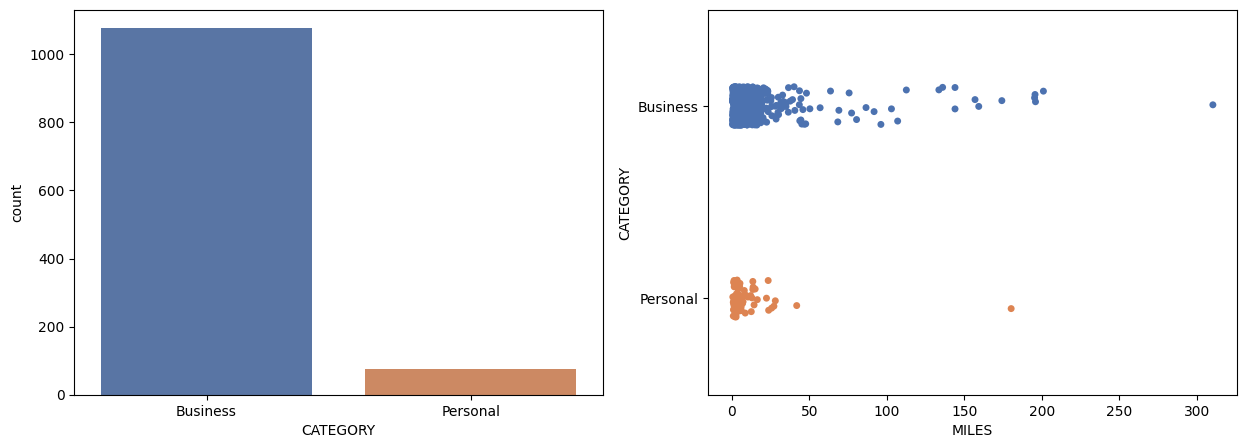

In [71]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.set_palette("deep")
sns.countplot(data = df,
              x = 'CATEGORY',
              hue = 'CATEGORY',
              ax = ax[0])

sns.stripplot(data=df, 
              y='CATEGORY', 
              x='MILES', 
              hue='CATEGORY', ax = ax[1])

plt.show()

- Most are business trip 
- The business could be further than personal

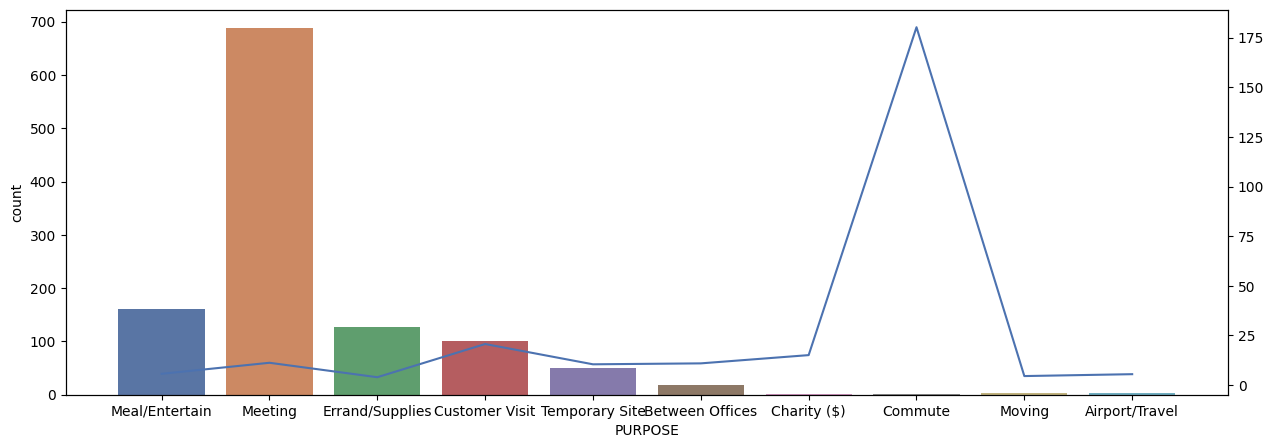

In [67]:
fig, ax = plt.subplots(figsize = (15,5))
sns.set_palette("deep")
sns.countplot(data = df,    
              x = 'PURPOSE',
              hue = 'PURPOSE',
              ax = ax)
ax1 = ax.twinx()
df_mean = df.groupby('PURPOSE')['MILES'].mean()
sns.lineplot(x = df_mean.index, 
            y = df_mean.values, 
            ax= ax1)
plt.xticks(rotation = 90)
plt.show()


- High amount of ride for meeting purpose, then meal/entrance
- High mile average for commuting purpose and customer visit

<Axes: xlabel='day-night', ylabel='count'>

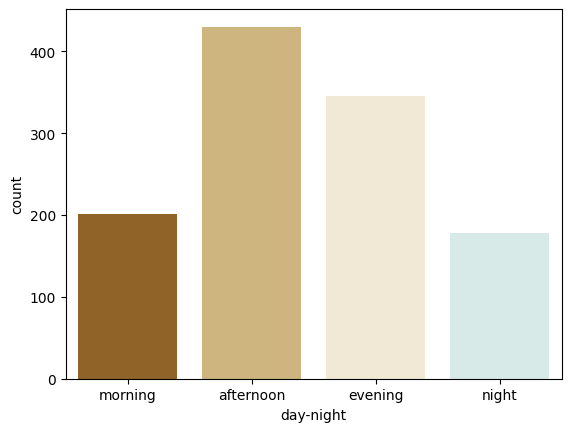

In [91]:
sns.countplot(data = df,
              x = 'day-night',
              hue = 'day-night')

- Most book during afternoon and evening

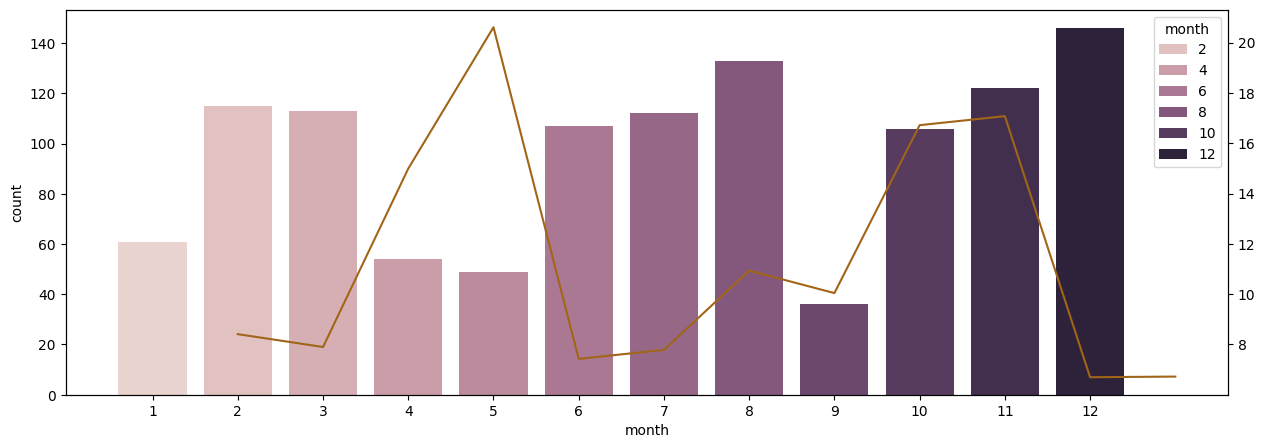

In [77]:
df['month'] = df['START_DATE'].dt.month
# Create a DataFrame with value counts of 'month'

fig, ax = plt.subplots(figsize = (15,5))
sns.set_palette("BrBG")
sns.countplot(data = df,    
              x = 'month',
              hue = 'month',
              ax = ax)
ax1 = ax.twinx()
df_mean = df.groupby('month')['MILES'].mean()
sns.lineplot(x = df_mean.index, 
            y = df_mean.values, 
            ax= ax1)
plt.xticks(rotation = 90)
plt.show()


- The amount of trip ins increase from 9 - 12
- The longest travel mile during 4-6

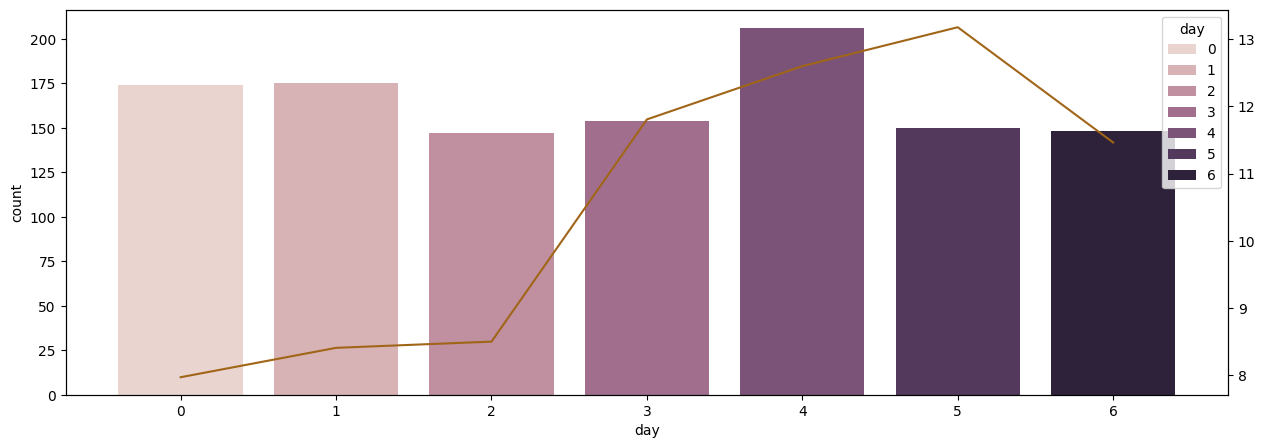

In [79]:
df['day'] = df['START_DATE'].dt.weekday
# Create a DataFrame with value counts of 'month'

fig, ax = plt.subplots(figsize = (15,5))
sns.set_palette("BrBG")
sns.countplot(data = df,    
              x = 'day',
              hue = 'day',
              ax = ax)
ax1 = ax.twinx()
df_mean = df.groupby('day')['MILES'].mean()
sns.lineplot(x = df_mean.index, 
            y = df_mean.values, 
            ax= ax1)
plt.xticks(rotation = 90)
plt.show()


- longe travel near the end of the week

<Axes: >

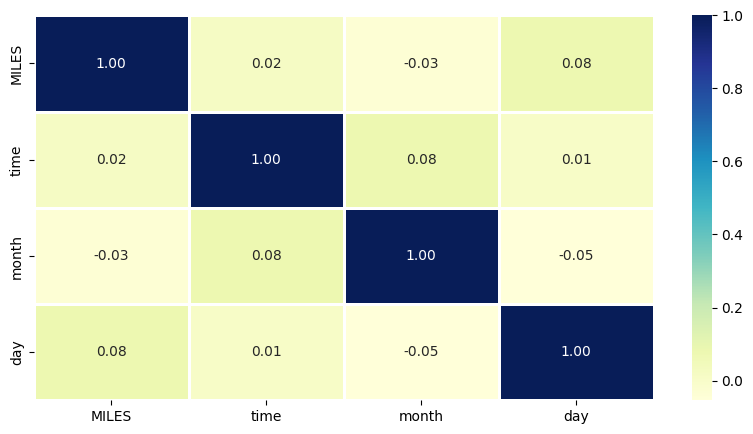

In [85]:
# Encode the categorical columns to conduct correlation
df_num = df.select_dtypes('number')

plt.figure(figsize = (10,5))
sns.heatmap(df_num.corr(),
            cmap = 'YlGnBu',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

there are no clear corellation

<Axes: >

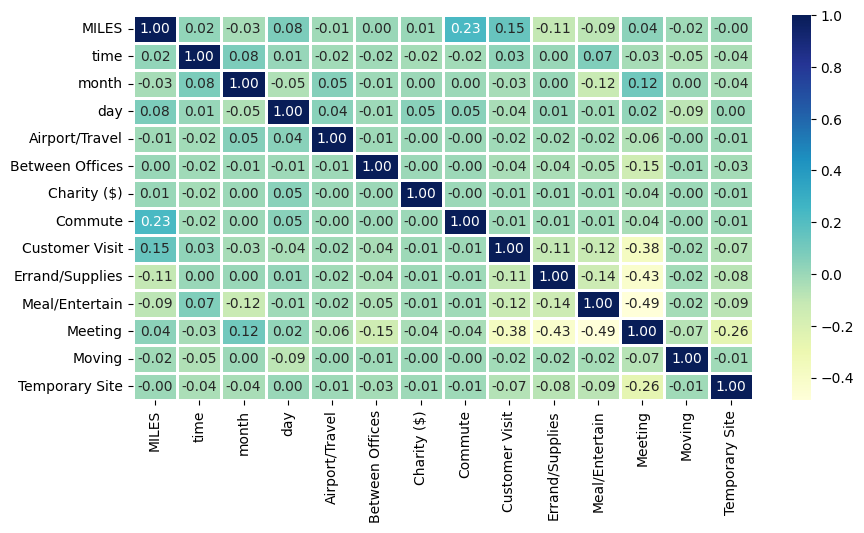

In [87]:
df_num = df.select_dtypes('number')
df_oh = pd.get_dummies(df['PURPOSE'])
df_num = pd.concat([df_num,df_oh],axis = 1)
plt.figure(figsize = (10,5))

sns.heatmap(df_num.corr(),
            cmap = 'YlGnBu',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

- only comute show slight correlation to miles


<Axes: >

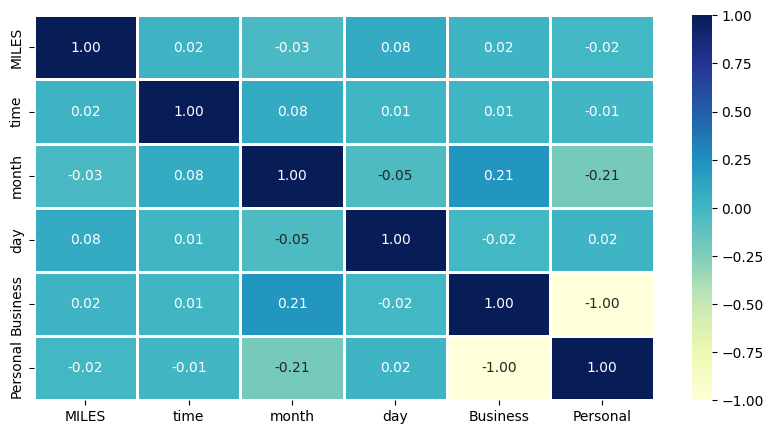

In [88]:
df_num = df.select_dtypes('number')
df_oh = pd.get_dummies(df['CATEGORY'])
df_num = pd.concat([df_num,df_oh],axis = 1)
plt.figure(figsize = (10,5))

sns.heatmap(df_num.corr(),
            cmap = 'YlGnBu',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

- slight correlation bt month and bussiness purpose

Summary
- Most are business trip
- The business could be further than personal
- High amount of ride for meeting purpose, then meal/entrance
- High mile average for commuting purpose and customer visit
- Most book during afternoon and evening
- The amount of trip ins increase from 9 - 12
- The longest travel mile during 4-6
- longe travel near the end of the week

Potential ideas:

- Trip Purpose Classification:
Build a classification model to predict the purpose of each trip (e.g., business, personal, meeting, customer visit) based on features such as miles traveled, total amount spent, and time of booking. 
It can prioritize commuting trips, meeting trips, or customer visit trips based on their importance and demand.
Enhanced Customer Experience, it can offer special discounts or promotions for commuting trips, provide priority boarding for meeting trips, or offer additional amenities for customer visit trips.

- Demand Forecasting:
Use machine learning to forecast future trip demand based on historical booking data, seasonal trends, and external factors to optimize resource allocation and service capacity.